# **Carbon DeFi Data Analysis**

### **Using Subgrounds Library**

* Import required packages for querying and data analysis
* Create a ```Subgrounds()``` object
* Load Carbon Subgraph
* Query ```users``` ordered by ```createdAtTimestamp```
* Select most recent ```trades``` per user
* Transform timestamp data to datetime using ```SyntheticField```
* Use ```query_df``` to convert data to pandas
* Save data to ```.csv```
* Plot relevant data using ```matplotlib```

In [1]:
from subgrounds import Subgrounds, SyntheticField
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set up the api key and subgraph id
API_KEY = '<API_KEY>'
SUBGRAPH_ID = '3oYNFcwAGk5mVtzzMTDjanoMRsZRCGk88EFRn75dLRyp'

url = f'https://gateway-arbitrum.network.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}'

# Load the subgraph and query the data
with Subgrounds() as sg:
    carbon = sg.load_subgraph(url)

    trade = carbon.Trade
    # Create a SyntheticField to format datetime
    trade.createdAtDatetime = SyntheticField.datetime_of_timestamp(trade.createdAtTimestamp)
    
    # FieldPath to query the oldest users 
    oldest_users = carbon.Query.users(
        first=100,
        orderBy='createdAtTimestamp',
        orderDirection='asc',
    )
    
    # Partial FieldPath to query the most recent trades from users
    recent_trades = oldest_users.trades(
        first=100,
        orderBy='createdAtTimestamp',
        orderDirection='desc',
    )
    
    # Define the fields to be queried  
    userFields = [
        oldest_users.id,
        recent_trades.id,
        recent_trades.createdAtDatetime,
        recent_trades.sourceAmount,
        recent_trades.targetAmount,
        recent_trades.tradingFeeAmount,
        recent_trades.pair.id,
        recent_trades.pair.token0.id,
        recent_trades.pair.token0.symbol,
        recent_trades.pair.token1.id,
        recent_trades.pair.token1.symbol,  
    ]    

    user_df = sg.query_df(userFields)
    user_df.to_csv('carbon_eth.csv', index=False)

### **Data Visualization**

In [25]:
user_df = pd.read_csv('carbon_eth.csv')
user_df.head(5)

,users_id,users_trades_id,users_trades_createdAtDatetime,users_trades_sourceAmount,users_trades_targetAmount,users_trades_tradingFeeAmount,users_trades_pair_id,users_trades_pair_token0_id,users_trades_pair_token0_symbol,users_trades_pair_token1_id,users_trades_pair_token1_symbol
0,0x4a3ca0cb4dcf6bc573ca4b538cab5fb0e01b5f19,0x2d1cfc4643dddd098f4788804cf8c22163fbfa5cfd6b...,2023-04-21 05:44:47,10010087,30000000000000000000000000,20021,0x6982508145454ce325ddbe47a25d4ec3d2311933-0xa...,0x6982508145454ce325ddbe47a25d4ec3d2311933,PEPE,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC
1,0x4a3ca0cb4dcf6bc573ca4b538cab5fb0e01b5f19,0x818061858e150bc8d74a466fe8dfac6876fc01509e75...,2023-04-20 12:06:23,2000000,1348629896743071054,2702665123733610,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c-0xa...,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,BNT,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC
2,0x4a3ca0cb4dcf6bc573ca4b538cab5fb0e01b5f19,0x27dc322ade1d48dd6f7b359585175383b8b9a2be2133...,2023-04-20 09:47:59,3098981468378530,6000000,6197962936758,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48-0xe...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH
3,0x4a3ca0cb4dcf6bc573ca4b538cab5fb0e01b5f19,0x7ba2cfb95b215b51752b0d313dbfc158261ff4c97cf4...,2023-04-20 08:50:23,1000000,498999999999999443,999999999999999,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c-0xa...,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,BNT,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC
4,0x4a3ca0cb4dcf6bc573ca4b538cab5fb0e01b5f19,0x10f2b6feb3423badbeb416e101cbe48d9a63065f725e...,2023-04-20 08:47:23,1803607218315157606,3000000,3607214436630316,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c-0xa...,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,BNT,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC


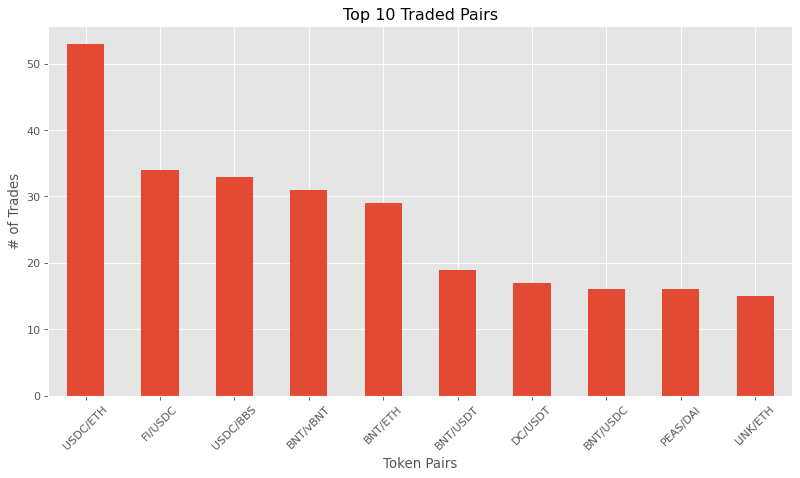

In [26]:
# Bar chart - Top (Recent) Traded Pairs / Total Fee Amount
user_df['users_trade_pairs_symbols'] = user_df['users_trades_pair_token0_symbol'] + '/' + user_df['users_trades_pair_token1_symbol']
pairs = user_df['users_trade_pairs_symbols'].value_counts()

plt.figure(figsize=(12, 6), dpi=80)
plt.style.use(style='ggplot')
pairs.head(10).plot(kind='bar', width=.5)

plt.xticks(rotation=45)
plt.ylabel('# of Trades')
plt.xlabel('Token Pairs')
plt.title('Top 10 Traded Pairs')
plt.show()